2015-04-15 18:03:29,838 - INFO - <ipython-input-1-eb13c6d3f18f> - 
Automated Run begin
which eigenvalues to search for = LI
Number of eigenvalues to return per sigma = 15
sigmas requested:
4.21207813405e-06j
8.4241562681e-06j
1.26362344021e-05j
INFO:autorun:
Automated Run begin
which eigenvalues to search for = LI
Number of eigenvalues to return per sigma = 15
sigmas requested:
4.21207813405e-06j
8.4241562681e-06j
1.26362344021e-05j
2015-04-15 18:03:29,839 - INFO - <ipython-input-1-eb13c6d3f18f> - creating model
INFO:autorun:creating model
2015-04-15 18:03:30,637 - INFO - MAC_logging - 
MAC model, m=0, Nk=1, Nl=3

Physical Parameters
Omega = 7.27e-05 rad/s
R = 3480.0 km
h = 80.0 km
rho = 1.00e+04 kg/m^3
nu = 1.00e+00 m/s^2
eta = 2.00e+00 m/s^2
omega_g = 1.45e-04 rad/s = 2.0*Omega
Bd = 5.00e-04 T, 5.00e+00 G

Non-Dimensional Parameters
t_star = 1.38e+04 s
r_star = 3.48e+06 m
u_star = 2.53e+02 m/s
B_star = 1.35e-03 T = 13.52 G
P_star = 6.40e+08 Pa = 0.64 GPa

G = 4.00e+00
E = 1.14e-09
E/

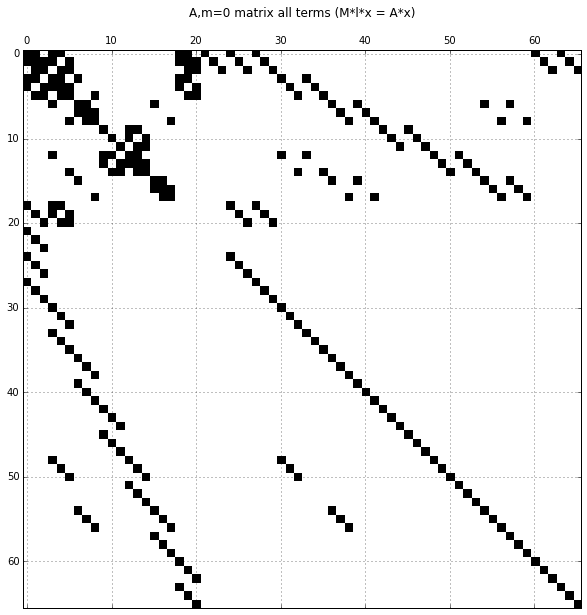

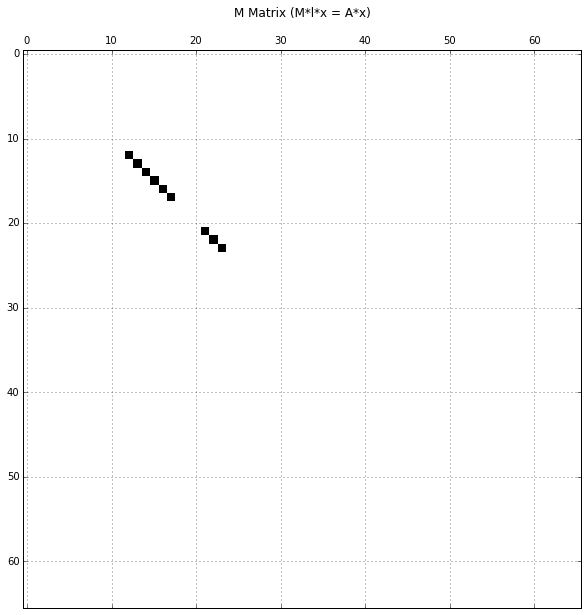

In [1]:
import numpy as np
import scipy as sp
import scipy.sparse as sparse
import scipy.sparse.linalg as LA
import matplotlib.pyplot as plt
import matplotlib.pylab as pyl
import matplotlib as mpl

import MAC_functions_braginsky_axisymmetric as mf
import MAC_plotting as mplt
import MAC_logging as mlog

from numpy import sin
from numpy import cos
import sys
from datetime import datetime
import cPickle as pkl
import os
%matplotlib inline

######################################################################
##########	Define Parameters	######################################
######################################################################

######################################################################
#### Edit These: ####

# mode to simulate
m = 0

# Size of grid
Nk = 1
Nl = 3
Nm = 1

# Set up variables to use
model_variables = ('ur','uth','uph','br','bth','bph','p','r_disp')
boundary_variables = ('ur','uth','uph','br','bth','bph','p')

# Physical Constants
R = 3480e3 # Outer core radius in m
Omega = 2*np.pi/(24.0*3600.0) # rotation rate in rad/s
rho = 1.e4	# density in kg/m^3
h = 80e3 # layer thickness in m
nu = 1. # momentum diffusivity in m^2/s
eta = 2. # magnetic diffusivity in m^2/s
mu_0 = 4.*np.pi*10.**-7 # vacuum permeability in (kg*m/(A^2s^2))
g = 10. # Gravity in m/s^2
drho_dr = -1e-1 # density gradient for boussinesq approximation in kg/m^4 (constant gradient in this model)
omega_g = 2*Omega # Buoyancy frequency in rad/s
T1 = 65.0*365.25*24*3600 # Period of first mode in seconds
Bd = (0.446e-2)*(4*np.pi*rho)**0.5*(mu_0/(4*np.pi))**0.5  # Dipole Field constant in Teslas (Bd = Br*cos(theta))
delta_C = np.sqrt(2*nu/(2*np.pi/T1))  # Core magnetic skin depth for first mode

### Parameters to set for automated run####
# sigmas = 10.**np.linspace(-4,-7,1)*1j
num_eigs =15
max_iter = 10000
which = 'LI'
dir_name = './output/automated_run_{0}_{1}/'.format(datetime.today().date(),datetime.today().time())

####
#### End Editable parameters ####
######################################################################

def ensure_dir(f):
	d = os.path.dirname(f)
	if not os.path.exists(d):
		os.makedirs(d)
ensure_dir(dir_name)


######## Create log file and direct all output to log file ####
logger = mlog.setup_custom_logger('autorun',dir_name+'autorun.log')


# Calculate Non-Dimensionalized Parameters
t_star = 1/Omega  # seconds
r_star = R	# meters
P_star = rho* r_star**2/t_star**2
B_star = (eta*mu_0*rho/t_star)**0.5
u_star = r_star/t_star
E = nu*t_star/r_star**2
Prm = nu/eta
G = (omega_g*t_star)**2
l1 = 2*np.pi/(T1/t_star)

######################## Important: LOOK HERE! #################
sigmas = [l1*1j*0.1, l1*1j*0.2, l1*1j*0.3]
################################################################

physical_constants = {'R':R,'Omega':Omega,'rho':rho,'h':h,'nu':nu,'eta':eta,'mu_0':mu_0,'omega_g':omega_g,'Bd':Bd,
					  't_star':t_star,'r_star':r_star,'u_star':u_star,'P_star':P_star,'B_star':B_star,
					  'E':E,'Prm':Prm,'G':G,'l1':l1,'delta_C':delta_C}

# Create model parameter vectors
SizeM = len(model_variables)*Nk*Nl+2*len(boundary_variables)*Nl
rmin = (R-h)/r_star
rmax = R/r_star
dr = (rmax-rmin)/(Nk)
r = np.linspace(rmin-dr/2.,rmax+dr/2.,num=Nk+2.) # r value at center of each cell
rm = np.linspace(rmin-dr,rmax,num=Nk+2.) # r value at plus border (top) of cell
rp = np.linspace(rmin,rmax+dr,num=Nk+2.) # r value at minus border (bottom) of cell
dth = np.pi/(Nl)
th = np.linspace(-dth/2.,np.pi+dth/2.,num=Nl+2.) # theta value at center of cell
thm = np.linspace(-dth,np.pi,num=Nl+2.) # theta value at plus border (top) of cell
thp = np.linspace(0,np.pi+dth,num=Nl+2.) # theta value at minus border (bottom) of cell
m_min = m
m_max = m
m_values = range(m_min,m_max+1)

### Set Background Fields
B0 = np.ones((Nk+2,Nl+2))*cos(th)*Bd/B_star
U0 = np.ones((Nk+2,Nl+2))*1e-16

model_parameters = {'Nk':Nk,'Nl':Nl,'Nm':Nm,'SizeM':SizeM,
					'dr':dr,'r':r,'rm':rm,'rp':rp,
					'dth':dth,'th':th,'thm':thm,'thp':thp,
					'm_values':m_values,
					'B0':B0, 'U0':U0
				   }

######## Start Log File ############
sigmaList = ''
for sigma in sigmas:
	sigmaList = sigmaList+ '\n'+str(sigma)

logger.info('\nAutomated Run begin' +
'\nwhich eigenvalues to search for = {0}'.format(which) +
'\nNumber of eigenvalues to return per sigma = {0}'.format(num_eigs) +
'\nsigmas requested:'+sigmaList)

######################################################################
##########	Create Model   ###########################################
######################################################################
logger.info('creating model')
model = mf.ModelBraginskyConductingCore(model_variables,boundary_variables,physical_constants,model_parameters)

A_matrices = {}
M_matrices = {}
A_matrices[m] = model.make_A(m)
M_matrices[m] = model.make_M(m)

### Plot Matrices if Deisred
mplt.plot_A(A_matrices[m],m)
mplt.plot_M(M_matrices[m],m)

mlog.log_model(logger,model)
